In [1]:
import argparse
import sys
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import wandb

from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
from Models_DTI4 import *

from Dataset_analyse_attention_weights import IG_Dataset

plt.rcParams['figure.dpi'] = 300

/home/grabeda2/miniconda3/envs/welo5_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle

def load_object(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [3]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = torch.nn.MSELoss()
    def forward(self, output, targets):
        return torch.sqrt(self.mse(output, targets))

In [4]:
# Where the inference should run
device_idx = 4

# Location of the test data
casf2013_dir = '/data/grbv/PDBbind/DTI_5/input_graphs_esm2_t6_8M/test_data/casf2013'
casf2016_dir = '/data/grbv/PDBbind/DTI_5/input_graphs_esm2_t6_8M/test_data/casf2016'
train_data_dir = '/data/grbv/PDBbind/DTI_5/input_graphs_esm2_t6_8M/training_data'

embedding = True
edge_features = True
atom_features = True

casf2013_dataset = IG_Dataset(casf2013_dir, embedding=embedding, edge_features=edge_features, atom_features=atom_features, masternode='all')
casf2016_dataset = IG_Dataset(casf2016_dir, embedding=embedding, edge_features=edge_features, atom_features=atom_features, masternode='all')
train_dataset = IG_Dataset(train_data_dir, embedding=embedding, edge_features=edge_features, atom_features=atom_features, masternode='all')

node_feat_dim = casf2013_dataset[0].x.shape[1]
edge_feat_dim = casf2013_dataset[0].edge_attr.shape[1]

casf2013_loader = DataLoader(dataset = casf2013_dataset, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True)
casf2016_loader = DataLoader(dataset = casf2016_dataset, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True)
#train_loader = DataLoader(dataset = train_dataset, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True)



In [5]:
node_feat_dim

360

In [6]:
edge_feat_dim

17

In [7]:
# Device Settings
num_threads = torch.get_num_threads() // 2
torch.set_num_threads(num_threads)

torch.cuda.set_device(device_idx)
device = torch.device(f'cuda:{device_idx}' if torch.cuda.is_available() else 'cpu')
print(device, torch.cuda.current_device(), torch.cuda.get_device_name())

cuda:4 4 Tesla P100-PCIE-16GB


In [8]:
# Emsemble Model

def load_model_state(model, state_dict_path):
    model.load_state_dict(torch.load(state_dict_path))
    model.eval()  # Set the model to evaluation mode
    return model


model_arch = 'GAT0_mn'
dropout_prob = 0
conv_dropout_prob = 0

model_class = getattr(sys.modules[__name__], model_arch)
models = [model_class(dropout_prob=dropout_prob, in_channels=node_feat_dim, edge_dim=edge_feat_dim, conv_dropout_prob=conv_dropout_prob).double().to(device) for _ in range(5)]

criterion = RMSELoss()

data_path = '/home/grabeda2/DTI/data/DTI5_c1'
model_paths = [os.path.join(data_path, file) for file in os.listdir(data_path) if file.startswith('r01_611fc1_mna_005_mult_d00')]
for mp in model_paths: print(mp)

models = [load_model_state(model, path) for model, path in zip(models, model_paths)]
models

/home/grabeda2/DTI/data/DTI5_c1/r01_611fc1_mna_005_mult_d00_f2_best_stdict.pt
/home/grabeda2/DTI/data/DTI5_c1/r01_611fc1_mna_005_mult_d00_f4_best_stdict.pt
/home/grabeda2/DTI/data/DTI5_c1/r01_611fc1_mna_005_mult_d00_f1_best_stdict.pt
/home/grabeda2/DTI/data/DTI5_c1/r01_611fc1_mna_005_mult_d00_f0_best_stdict.pt
/home/grabeda2/DTI/data/DTI5_c1/r01_611fc1_mna_005_mult_d00_f3_best_stdict.pt


[GAT0_mn(
   (conv1): GATv2Conv(360, 256, heads=4)
   (conv2): GATv2Conv(1024, 64, heads=4)
   (dropout_layer): Dropout(p=0, inplace=False)
   (fc1): Linear(in_features=256, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=1, bias=True)
 ),
 GAT0_mn(
   (conv1): GATv2Conv(360, 256, heads=4)
   (conv2): GATv2Conv(1024, 64, heads=4)
   (dropout_layer): Dropout(p=0, inplace=False)
   (fc1): Linear(in_features=256, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=1, bias=True)
 ),
 GAT0_mn(
   (conv1): GATv2Conv(360, 256, heads=4)
   (conv2): GATv2Conv(1024, 64, heads=4)
   (dropout_layer): Dropout(p=0, inplace=False)
   (fc1): Linear(in_features=256, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=1, bias=True)
 ),
 GAT0_mn(
   (conv1): GATv2Conv(360, 256, heads=4)
   (conv2): GATv2Conv(1024, 64, heads=4)
   (dropout_layer): Dropout(p=0, inplace=False)
   (fc1): Linear(in_features=256, out_features=64, bias=True)


In [9]:
# Evaluation Function
#-------------------------------------------------------------------------------------------------------------------------------
def evaluate(models, loader, criterion, device):
    
    # Initialize variables to accumulate the evaluation results
    total_loss = 0.0
    y_true = []
    y_pred = []

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        for graphbatch in loader:

            graphbatch.to(device)
            targets = graphbatch.y

            # Forward pass EMSEMBLE MODEL
            outputs = []

            for model in models: 
                outputs.append(model(graphbatch).view(-1))
                
            output = torch.mean(torch.stack(outputs), dim=0)    
            loss = criterion(output, targets)

            # Accumulate loss and collect the true and predicted values for later use
            total_loss += loss.item()
            y_true.extend(targets.tolist())
            y_pred.extend(output.tolist())


    # Calculate evaluation metrics
    eval_loss = total_loss / len(loader)

    # Pearson Correlation Coefficient
    corr_matrix = np.corrcoef(y_true, y_pred)
    r = corr_matrix[0, 1]

    # R2 Score
    r2_score = 1 - np.sum((np.array(y_true) - np.array(y_pred)) ** 2) / np.sum((np.array(y_true) - np.mean(np.array(y_true))) ** 2)

    # RMSE in pK unit
    min=0
    max=16
    true_labels_unscaled = torch.tensor(y_true) * (max - min) + min
    predictions_unscaled = torch.tensor(y_pred) * (max - min) + min
    criter = RMSELoss()
    rmse = criter(predictions_unscaled, true_labels_unscaled)

    return eval_loss, r, rmse, r2_score, true_labels_unscaled, predictions_unscaled
#-------------------------------------------------------------------------------------------------------------------------------


In [10]:
# loss, r, rmse, r2, y_true, y_pred
casf2016_metrics = evaluate(models, casf2016_loader, criterion, device)
casf2013_metrics = evaluate(models, casf2013_loader, criterion, device)
#train_metrics = evaluate(models, train_loader, criterion, device)

In [11]:
# Plotting Functions
#-------------------------------------------------------------------------------------------------------------------------
def plot_predictions(y_true, y_pred, title, label):
    
    plt.style.use('ggplot')
    axislim = 16
    fig = plt.figure(figsize=(8, 8))  # Set the figure size as needed

    plt.scatter(y_true, y_pred, alpha=0.5, c='blue', label=label)

    plt.plot([0, axislim], [0, axislim], color='red', linestyle='--')
    plt.xlabel('True pK Values')
    plt.ylabel('Predicted pK Values')
    plt.ylim(0, axislim)
    plt.xlim(0, axislim)
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    plt.title(title)
    
    #plt.rcParams['figure.dpi']=300

    plt.legend()
    return fig

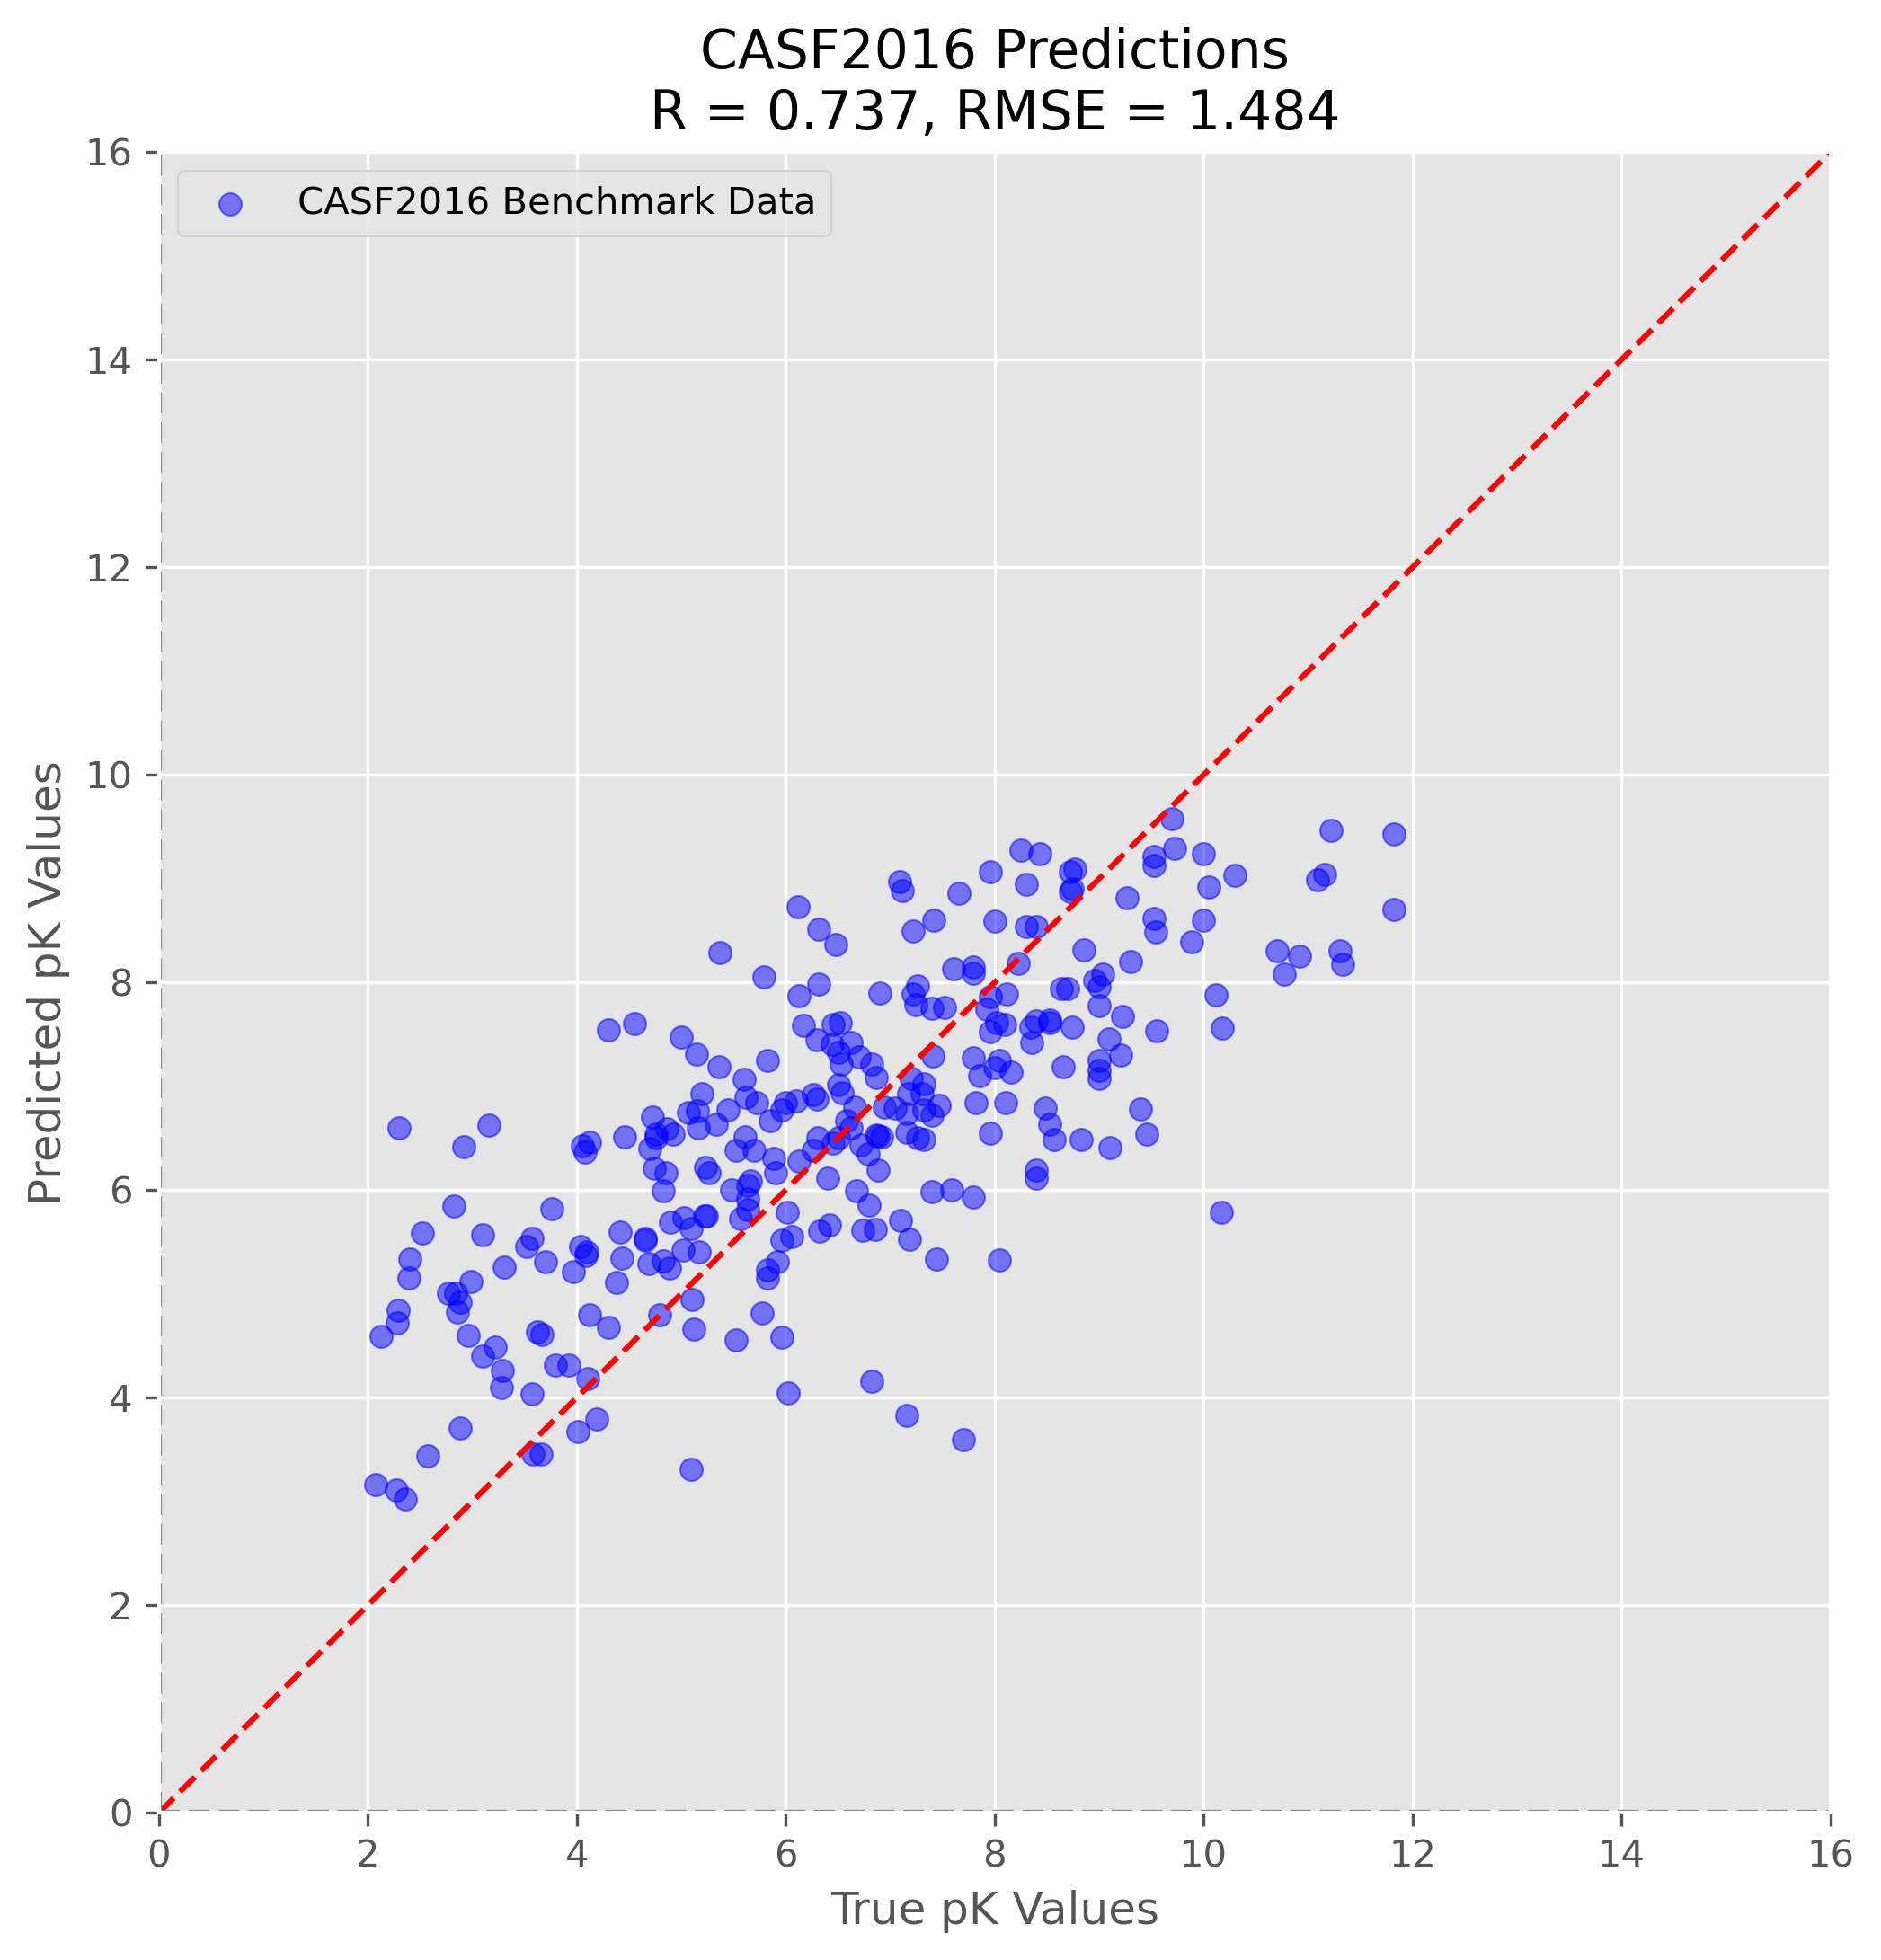

In [12]:
# Plot the predictions
loss, r, rmse, r2, y_true, y_pred = casf2016_metrics

best_predictions = plot_predictions(y_true, y_pred,
                                    f"CASF2016 Predictions\nR = {r:.3f}, RMSE = {rmse:.3f}", 
                                    'CASF2016 Benchmark Data')

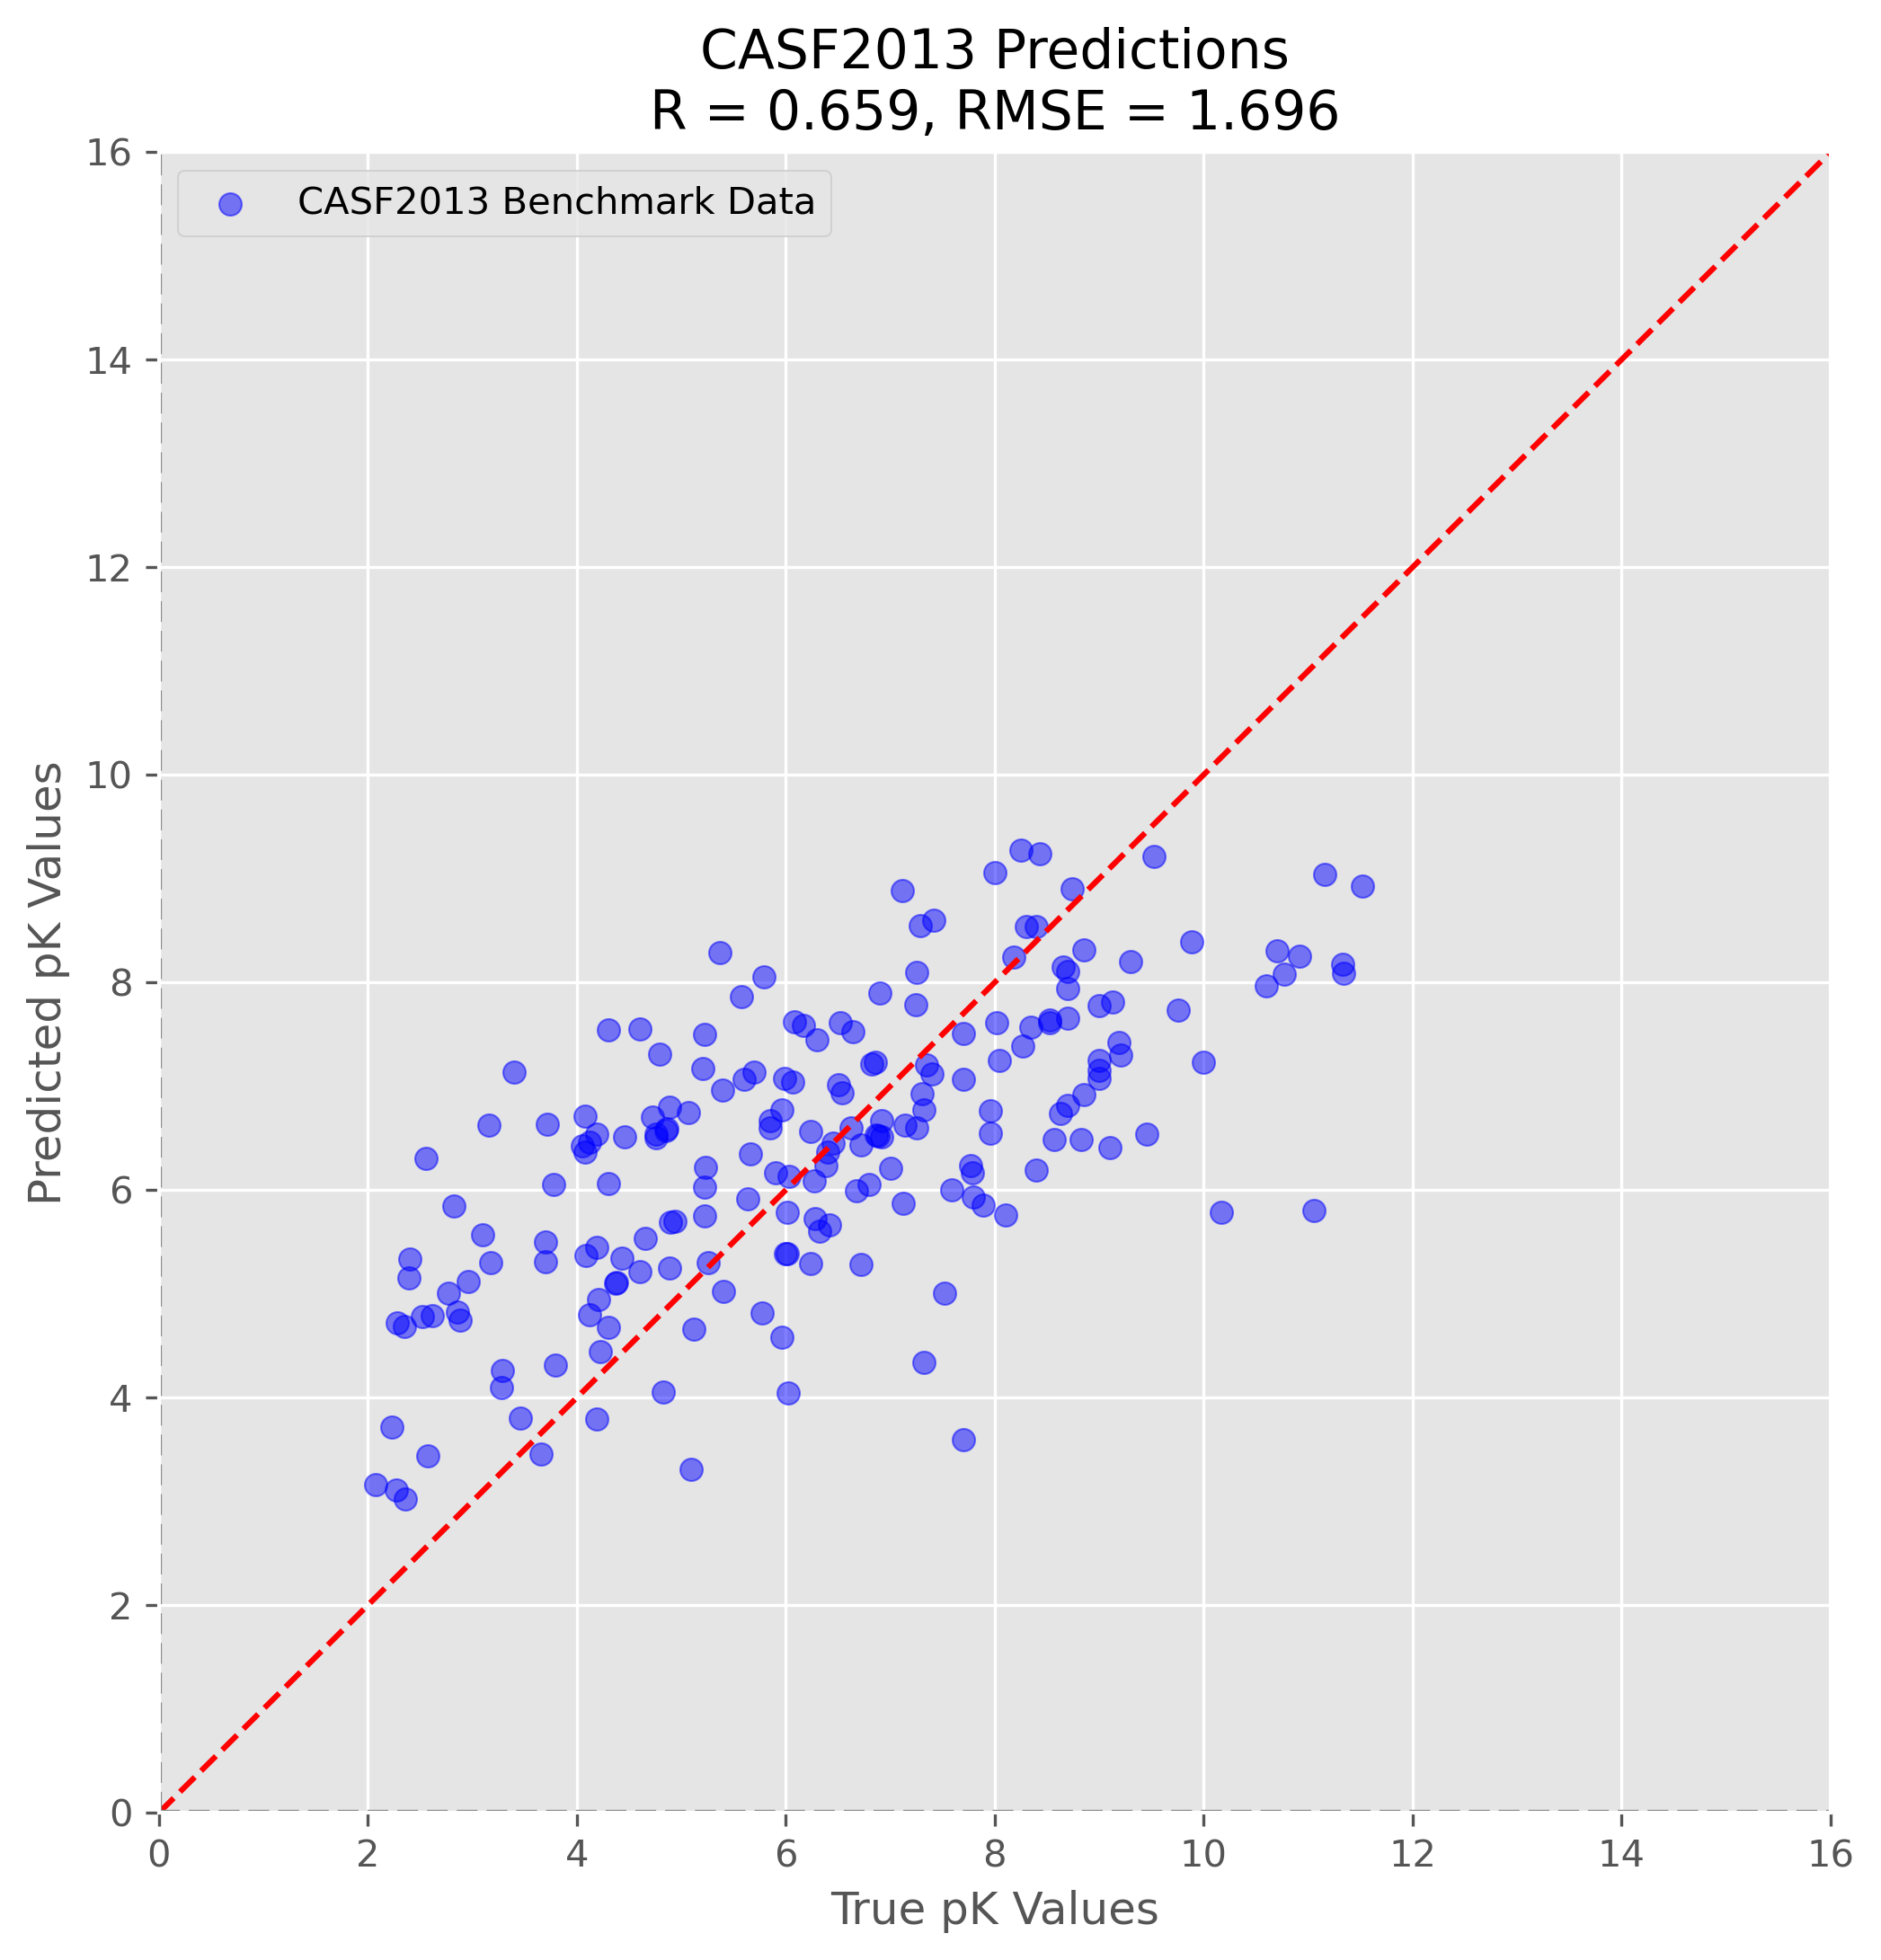

In [13]:
# Plot the predictions
loss, r, rmse, r2, y_true, y_pred = casf2013_metrics
best_predictions = plot_predictions(y_true, y_pred,
                                    f"CASF2013 Predictions\nR = {r:.3f}, RMSE = {rmse:.3f}",
                                    'CASF2013 Benchmark Data')

In [14]:
# Plot the predictions
# loss, r, rmse, r2, y_true, y_pred = train_metrics
# best_predictions = plot_predictions(y_true, y_pred,
#                                     f"Training Set\nR = {r:.3f}, RMSE = {rmse:.3f}",
#                                     'PDBbind Training Data')

### Analyse Attention Weights

In [15]:
# class GAT0b_mnp_return_w(torch.nn.Module):
#     def __init__(self, dropout_prob, in_channels, edge_dim, conv_dropout_prob):
#         super(GAT0b_mnp_return_w, self).__init__()

#         #Convolutional Layers
#         self.conv1 = GATv2Conv(in_channels, 512, edge_dim=edge_dim, heads=4, dropout=conv_dropout_prob)
#         self.conv2 = GATv2Conv(2048, 128, edge_dim=edge_dim, heads=4, dropout=conv_dropout_prob)
        
#         self.dropout_layer = torch.nn.Dropout(dropout_prob)
#         self.fc1 = torch.nn.Linear(1024, 64)
#         self.fc2 = torch.nn.Linear(64, 1)

#     def forward(self, graphbatch):
#         x, w = self.conv1(graphbatch.x, graphbatch.edge_index, graphbatch.edge_attr, return_attention_weights=True)
#         print(x.shape)
#         print(x.shape)
#         x = F.relu(x)
#         x, w = self.conv2(x, graphbatch.edge_index, graphbatch.edge_attr, return_attention_weights=True)
#         x = F.relu(x)

#         # Pool the nodes of each interaction graph
#         last_node_indeces = graphbatch.n_nodes.cumsum(dim=0) - 1
#         master_node_features = x[last_node_indeces]

#         master_node_features = torch.cat((master_node_features, global_add_pool(x, batch=graphbatch.batch)), dim=1)

#         x = self.dropout_layer(master_node_features)
#         # Fully-Connected Layers
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         return x, w

In [16]:
# class GAT0_return_w(torch.nn.Module):
#     def __init__(self, dropout_prob, in_channels, edge_dim, conv_dropout_prob):
#         super(GAT0_return_w, self).__init__()

#         #Convolutional Layers
#         self.conv1 = GATv2Conv(in_channels, 256, edge_dim=edge_dim, heads=4, dropout=conv_dropout_prob)
#         self.conv2 = GATv2Conv(1024, 64, edge_dim=edge_dim, heads=4, dropout=conv_dropout_prob)
        
#         self.dropout_layer = torch.nn.Dropout(dropout_prob)
#         self.fc1 = torch.nn.Linear(256, 64)
#         self.fc2 = torch.nn.Linear(64, 1)

#     def forward(self, graphbatch):
        
#         x = self.conv1(graphbatch.x, graphbatch.edge_index, graphbatch.edge_attr)
#         x = F.relu(x)
#         x, w = self.conv2(x, graphbatch.edge_index, graphbatch.edge_attr, return_attention_weights=True)
#         x = F.relu(x)

#         # Pool the nodes of each interaction graph
#         x = global_add_pool(x, batch=graphbatch.batch)
#         x = self.dropout_layer(x)

#         # Fully-Connected Layers
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         return x, w

In [17]:
class GAT0_mn_return_w(torch.nn.Module):
    def __init__(self, dropout_prob, in_channels, edge_dim, conv_dropout_prob):
        super(GAT0_mn_return_w, self).__init__()

        #Convolutional Layers
        self.conv1 = GATv2Conv(in_channels, 256, edge_dim=edge_dim, heads=4, dropout=conv_dropout_prob)
        self.conv2 = GATv2Conv(1024, 64, edge_dim=edge_dim, heads=4, dropout=conv_dropout_prob)
        
        self.dropout_layer = torch.nn.Dropout(dropout_prob)
        self.fc1 = torch.nn.Linear(256, 64)
        self.fc2 = torch.nn.Linear(64, 1)

    def forward(self, graphbatch):
        x, w1 = self.conv1(graphbatch.x, graphbatch.edge_index, graphbatch.edge_attr, return_attention_weights=True)
        x = F.relu(x)
        x, w2 = self.conv2(x, graphbatch.edge_index, graphbatch.edge_attr, return_attention_weights=True)
        x = F.relu(x)

        # Pool the nodes of each interaction graph
        last_node_indeces = graphbatch.n_nodes.cumsum(dim=0) - 1
        master_node_features = x[last_node_indeces]

        x = self.dropout_layer(master_node_features)
        # Fully-Connected Layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x, w1, w2

In [18]:
def evaluate_weights(model, graph, criterion, device):
    
    # Initialize variables to accumulate the evaluation results
    total_loss = 0.0

    # Disable gradient calculation during evaluation
    with torch.no_grad():
    

        graph.to(device)
        target = graph.y
        print(target)

        # Forward pass EMSEMBLE MODEL
        
        output, w1, w2 = model(graph)

        loss = criterion(output.view(-1), target)

        # Accumulate loss and collect the true and predicted values for later use
        total_loss += loss.item()


    # Calculate evaluation metrics
    eval_loss = total_loss# / len(loader)

    # Pearson Correlation Coefficient
    # corr_matrix = np.corrcoef(y_true, y_pred)
    # r = corr_matrix[0, 1]

    # R2 Score
    # r2_score = 1 - np.sum((np.array(y_true) - np.array(y_pred)) ** 2) / np.sum((np.array(y_true) - np.mean(np.array(y_true))) ** 2)

    # RMSE in pK unit
    min=0
    max=16
    true_labels_unscaled = target * (max - min) + min
    predictions_unscaled = output * (max - min) + min
    # criter = RMSELoss()
    # rmse = criter(predictions_unscaled, true_labels_unscaled)

    edges = w1[0].cpu()
    weights = torch.concatenate([w1[1], w2[1]], axis=1).cpu()

    return eval_loss, true_labels_unscaled, predictions_unscaled, edges, weights
    return eval_loss, r, rmse, r2_score, true_labels_unscaled, predictions_unscaled
#-------------------------------------------------------------------------------------------------------------------------------

In [19]:
# Emsemble Model

def load_model_state(model, state_dict_path):
    model.load_state_dict(torch.load(state_dict_path))
    model.eval()  # Set the model to evaluation mode
    return model

conv_dropout_prob = 0
dropout_prob = 0.1


model = GAT0_mn_return_w(dropout_prob=dropout_prob, in_channels=node_feat_dim, edge_dim=edge_feat_dim, conv_dropout_prob=conv_dropout_prob).double().to(device)
criterion = RMSELoss()

data_path = '/home/grabeda2/DTI/data/DTI5_c1'
model_paths = [os.path.join(data_path, file) for file in os.listdir(data_path) if file.startswith('r01_611fc1_mna_005_mult_d00')]
model_path = model_paths[0]
print(os.path.basename(model_path))


model = load_model_state(model, model_path)
model

r01_611fc1_mna_005_mult_d00_f2_best_stdict.pt


GAT0_mn_return_w(
  (conv1): GATv2Conv(360, 256, heads=4)
  (conv2): GATv2Conv(1024, 64, heads=4)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [20]:
suitable_graphs = []

for grph in casf2016_dataset:
    if grph.y > 0.6 and grph.x.shape[0]<60:
        suitable_graphs.append(grph)

suitable_graphs

[Data(x=[47, 360], edge_index=[2, 415], edge_attr=[415, 17], y=0.6178785404808227, pos=[47, 3], n_nodes=47, id='1e66', n_lig_nodes=21),
 Data(x=[59, 360], edge_index=[2, 605], edge_attr=[605, 17], y=0.6438143747289988, pos=[59, 3], n_nodes=59, id='2p15', n_lig_nodes=32),
 Data(x=[53, 360], edge_index=[2, 459], edge_attr=[459, 17], y=0.6928866342260177, pos=[53, 3], n_nodes=53, id='5c2h', n_lig_nodes=31),
 Data(x=[59, 360], edge_index=[2, 497], edge_attr=[497, 17], y=0.6278598431600422, pos=[59, 3], n_nodes=59, id='4rfm', n_lig_nodes=36),
 Data(x=[45, 360], edge_index=[2, 457], edge_attr=[457, 17], y=0.6320943296767199, pos=[45, 3], n_nodes=45, id='1y6r', n_lig_nodes=20),
 Data(x=[35, 360], edge_index=[2, 321], edge_attr=[321, 17], y=0.6358703248311983, pos=[35, 3], n_nodes=35, id='3u8n', n_lig_nodes=17),
 Data(x=[50, 360], edge_index=[2, 505], edge_attr=[505, 17], y=0.7389942963090199, pos=[50, 3], n_nodes=50, id='4f3c', n_lig_nodes=23),
 Data(x=[53, 360], edge_index=[2, 455], edge_att

In [21]:
for graph in suitable_graphs:

    loss, true, pred, edges, attention_weights = evaluate_weights(model, graph, criterion, device)
    print(true.item(), pred.item())

tensor(0.6179, device='cuda:4', dtype=torch.float64)
9.886056647693163 8.938366212664507
tensor(0.6438, device='cuda:4', dtype=torch.float64)
10.301029995663981 8.670940461321074
tensor(0.6929, device='cuda:4', dtype=torch.float64)
11.086186147616283 9.32016260599289
tensor(0.6279, device='cuda:4', dtype=torch.float64)
10.045757490560675 9.431027802216425
tensor(0.6321, device='cuda:4', dtype=torch.float64)
10.113509274827518 7.884655050799644
tensor(0.6359, device='cuda:4', dtype=torch.float64)
10.173925197299173 7.729422030906916
tensor(0.7390, device='cuda:4', dtype=torch.float64)
11.823908740944319 8.709464072513285
tensor(0.6250, device='cuda:4', dtype=torch.float64)
10.0 8.527510154152354
tensor(0.6250, device='cuda:4', dtype=torch.float64)
10.0 9.352573640049018
tensor(0.7063, device='cuda:4', dtype=torch.float64)
11.301029995663981 8.217034661785462
tensor(0.7080, device='cuda:4', dtype=torch.float64)
11.327902142064282 7.970340633250309
tensor(0.6687, device='cuda:4', dtype=to

/home/grabeda2/miniconda3/envs/welo5_gpu/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [22]:
graph = suitable_graphs[3]
graph.cpu()

Data(x=[59, 360], edge_index=[2, 497], edge_attr=[497, 17], y=0.6278598431600422, pos=[59, 3], n_nodes=59, id='4rfm', n_lig_nodes=36)

In [23]:
attention_weights.shape

torch.Size([451, 8])

In [24]:
edges.shape

torch.Size([2, 451])

In [25]:
master_node_index = torch.max(edges)
print(master_node_index)

tensor(51)


In [26]:
#condition1 = edges[0, :] != master_node_index
condition2 = edges[1, :] == master_node_index

#combined_condition = condition1 & condition2

In [27]:
master_node_edges = torch.where(condition2)[0]
master_node_edges

tensor([348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,
        362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
        376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389,
        390, 391, 392, 393, 394, 395, 396, 397, 398, 450])

In [28]:
input_nodes = edges[0][master_node_edges]
input_nodes

tensor([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 51])

In [29]:
mn_w_conv = attention_weights[master_node_edges]
print(mn_w_conv.shape)

torch.Size([52, 8])


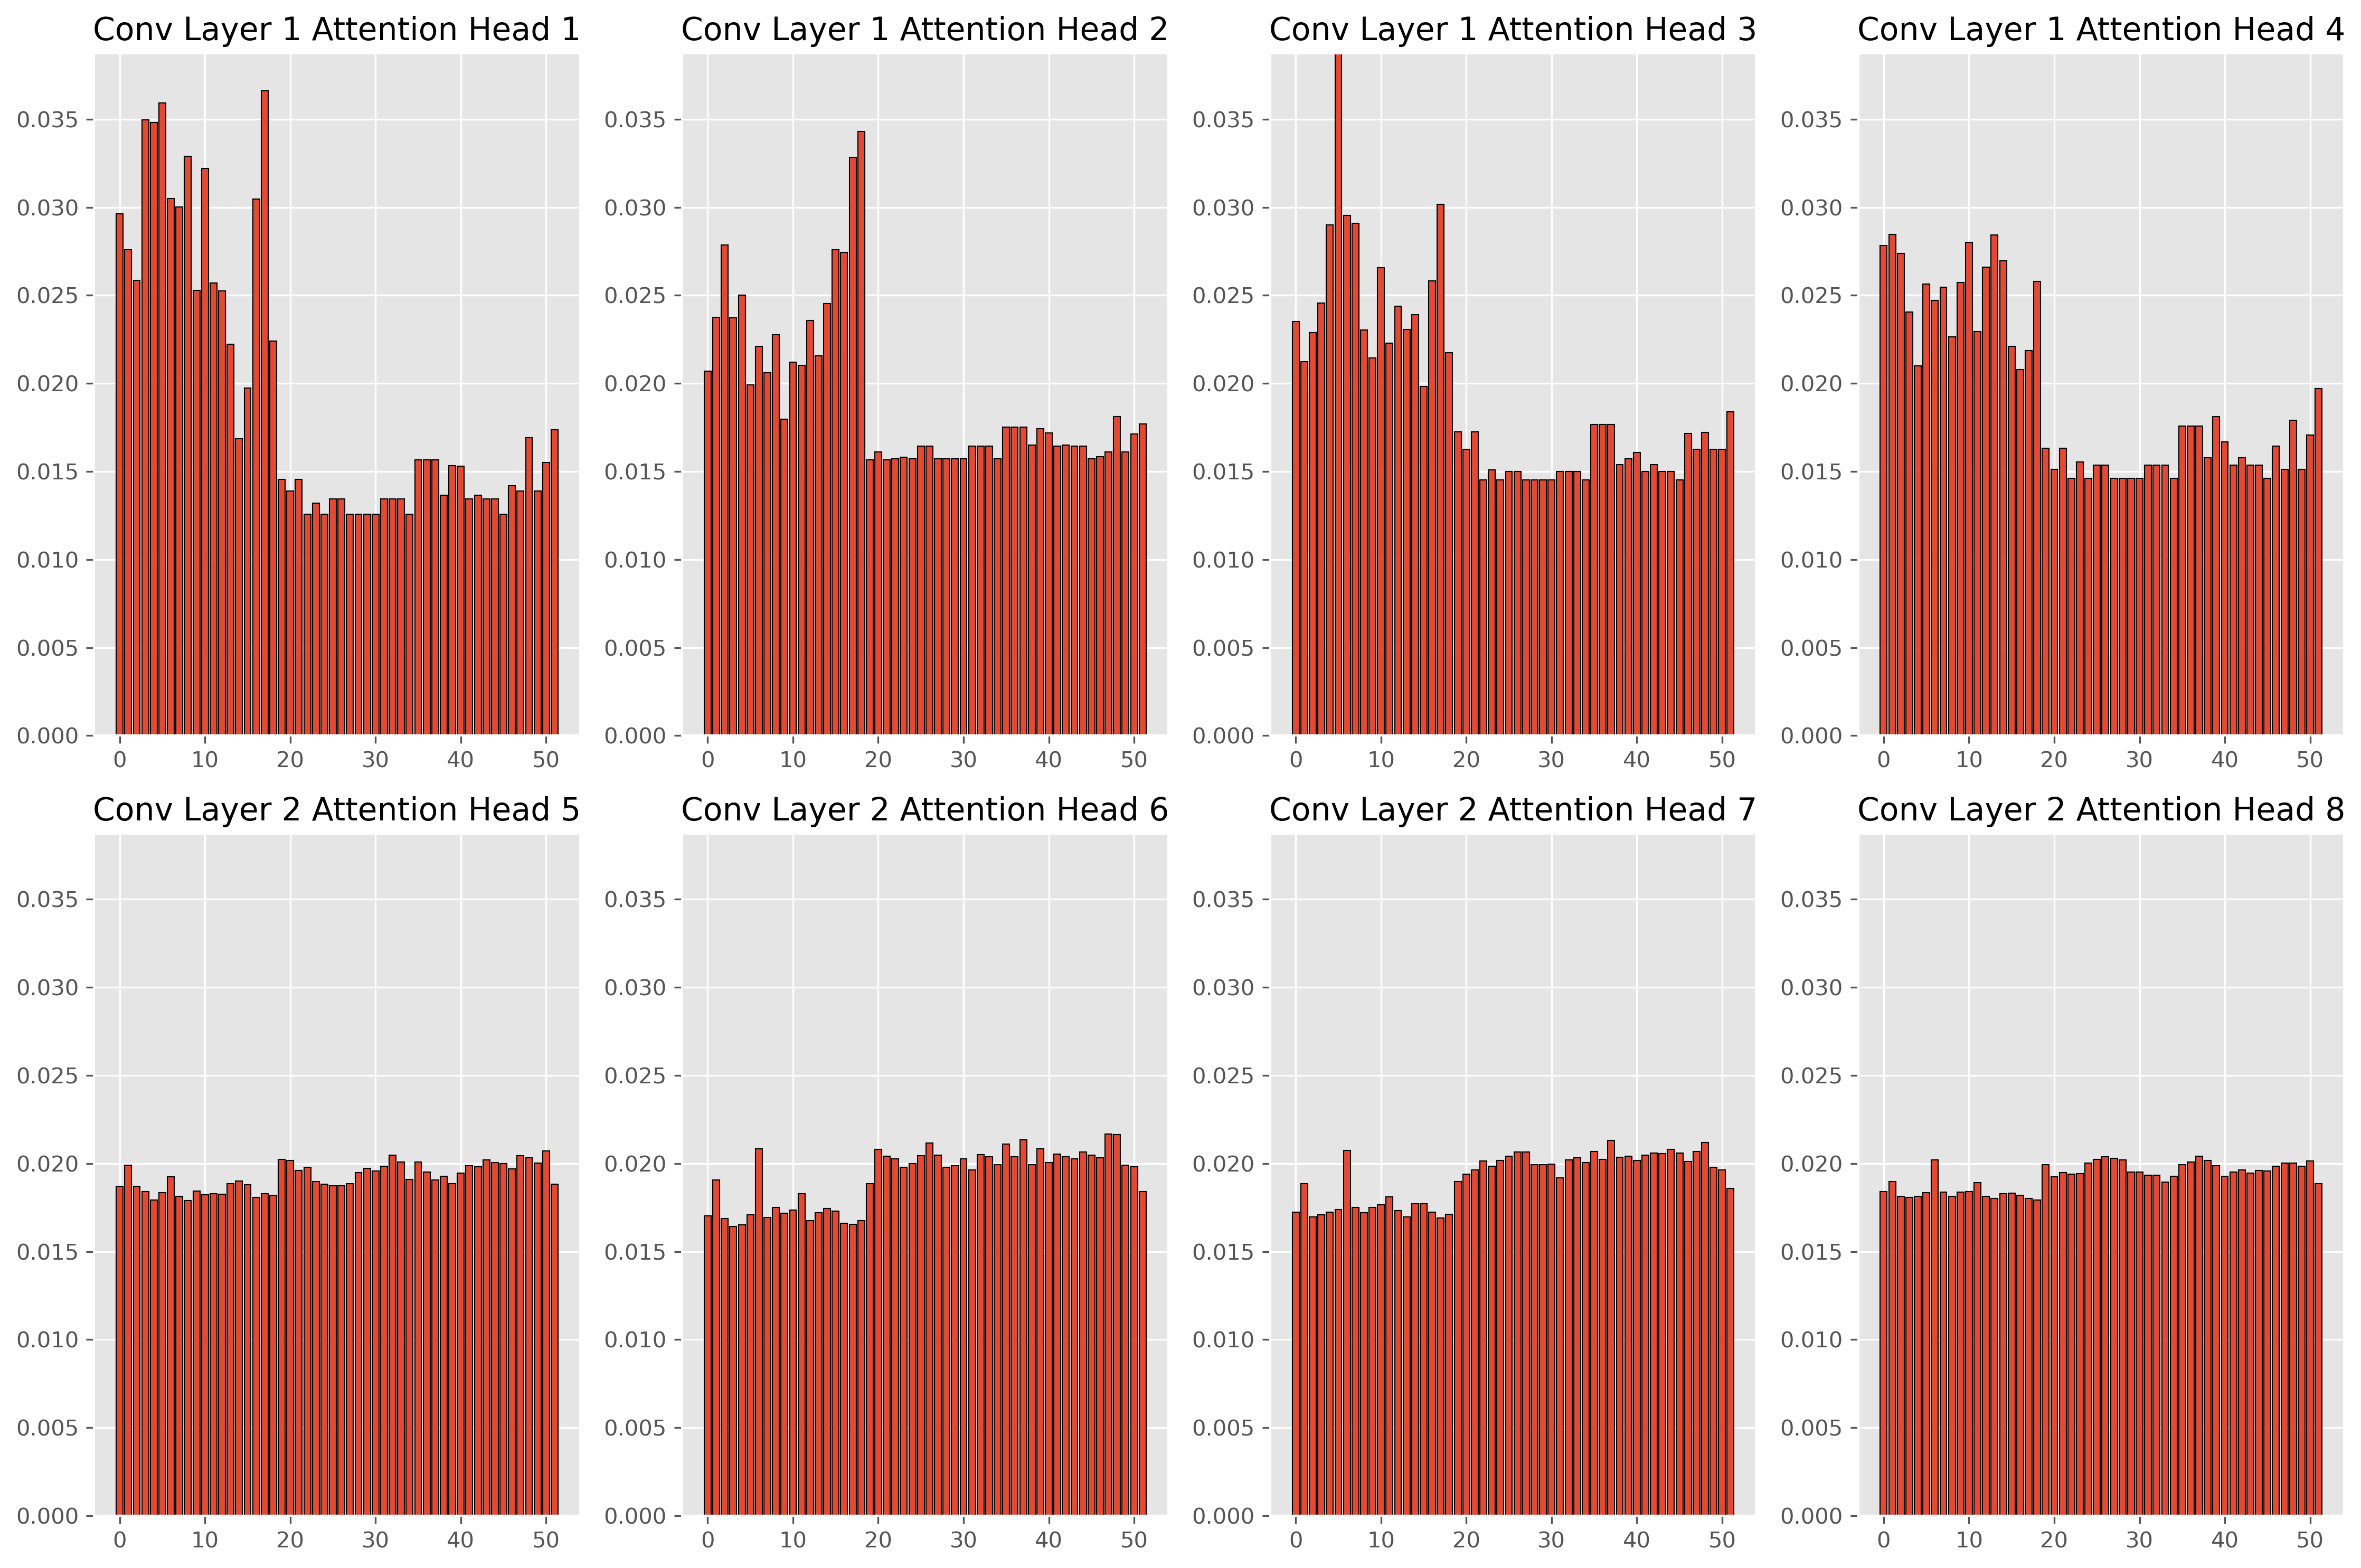

In [30]:
import torch
import matplotlib.pyplot as plt

# Assuming you have a torch tensor named 'tensor' with shape (78, 8)

# Calculate the maximum value across all columns for consistent y-axis range
max_value = mn_w_conv.max().item()

# Create a figure with 2x4 subplots
fig, axs = plt.subplots(2, 4, figsize=(15, 10))

# Iterate over each subplot and plot histogram for each column
for i in range(2):
    for j in range(4):
        col = i * 4 + j
        axs[i, j].bar(range(mn_w_conv.shape[0]), mn_w_conv[:, col], edgecolor='black')
        axs[i, j].set_title(f'Conv Layer {i+1} Attention Head {col + 1}')
        axs[i, j].set_ylim(0, max_value)  # Set the same y-axis range for all plots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()



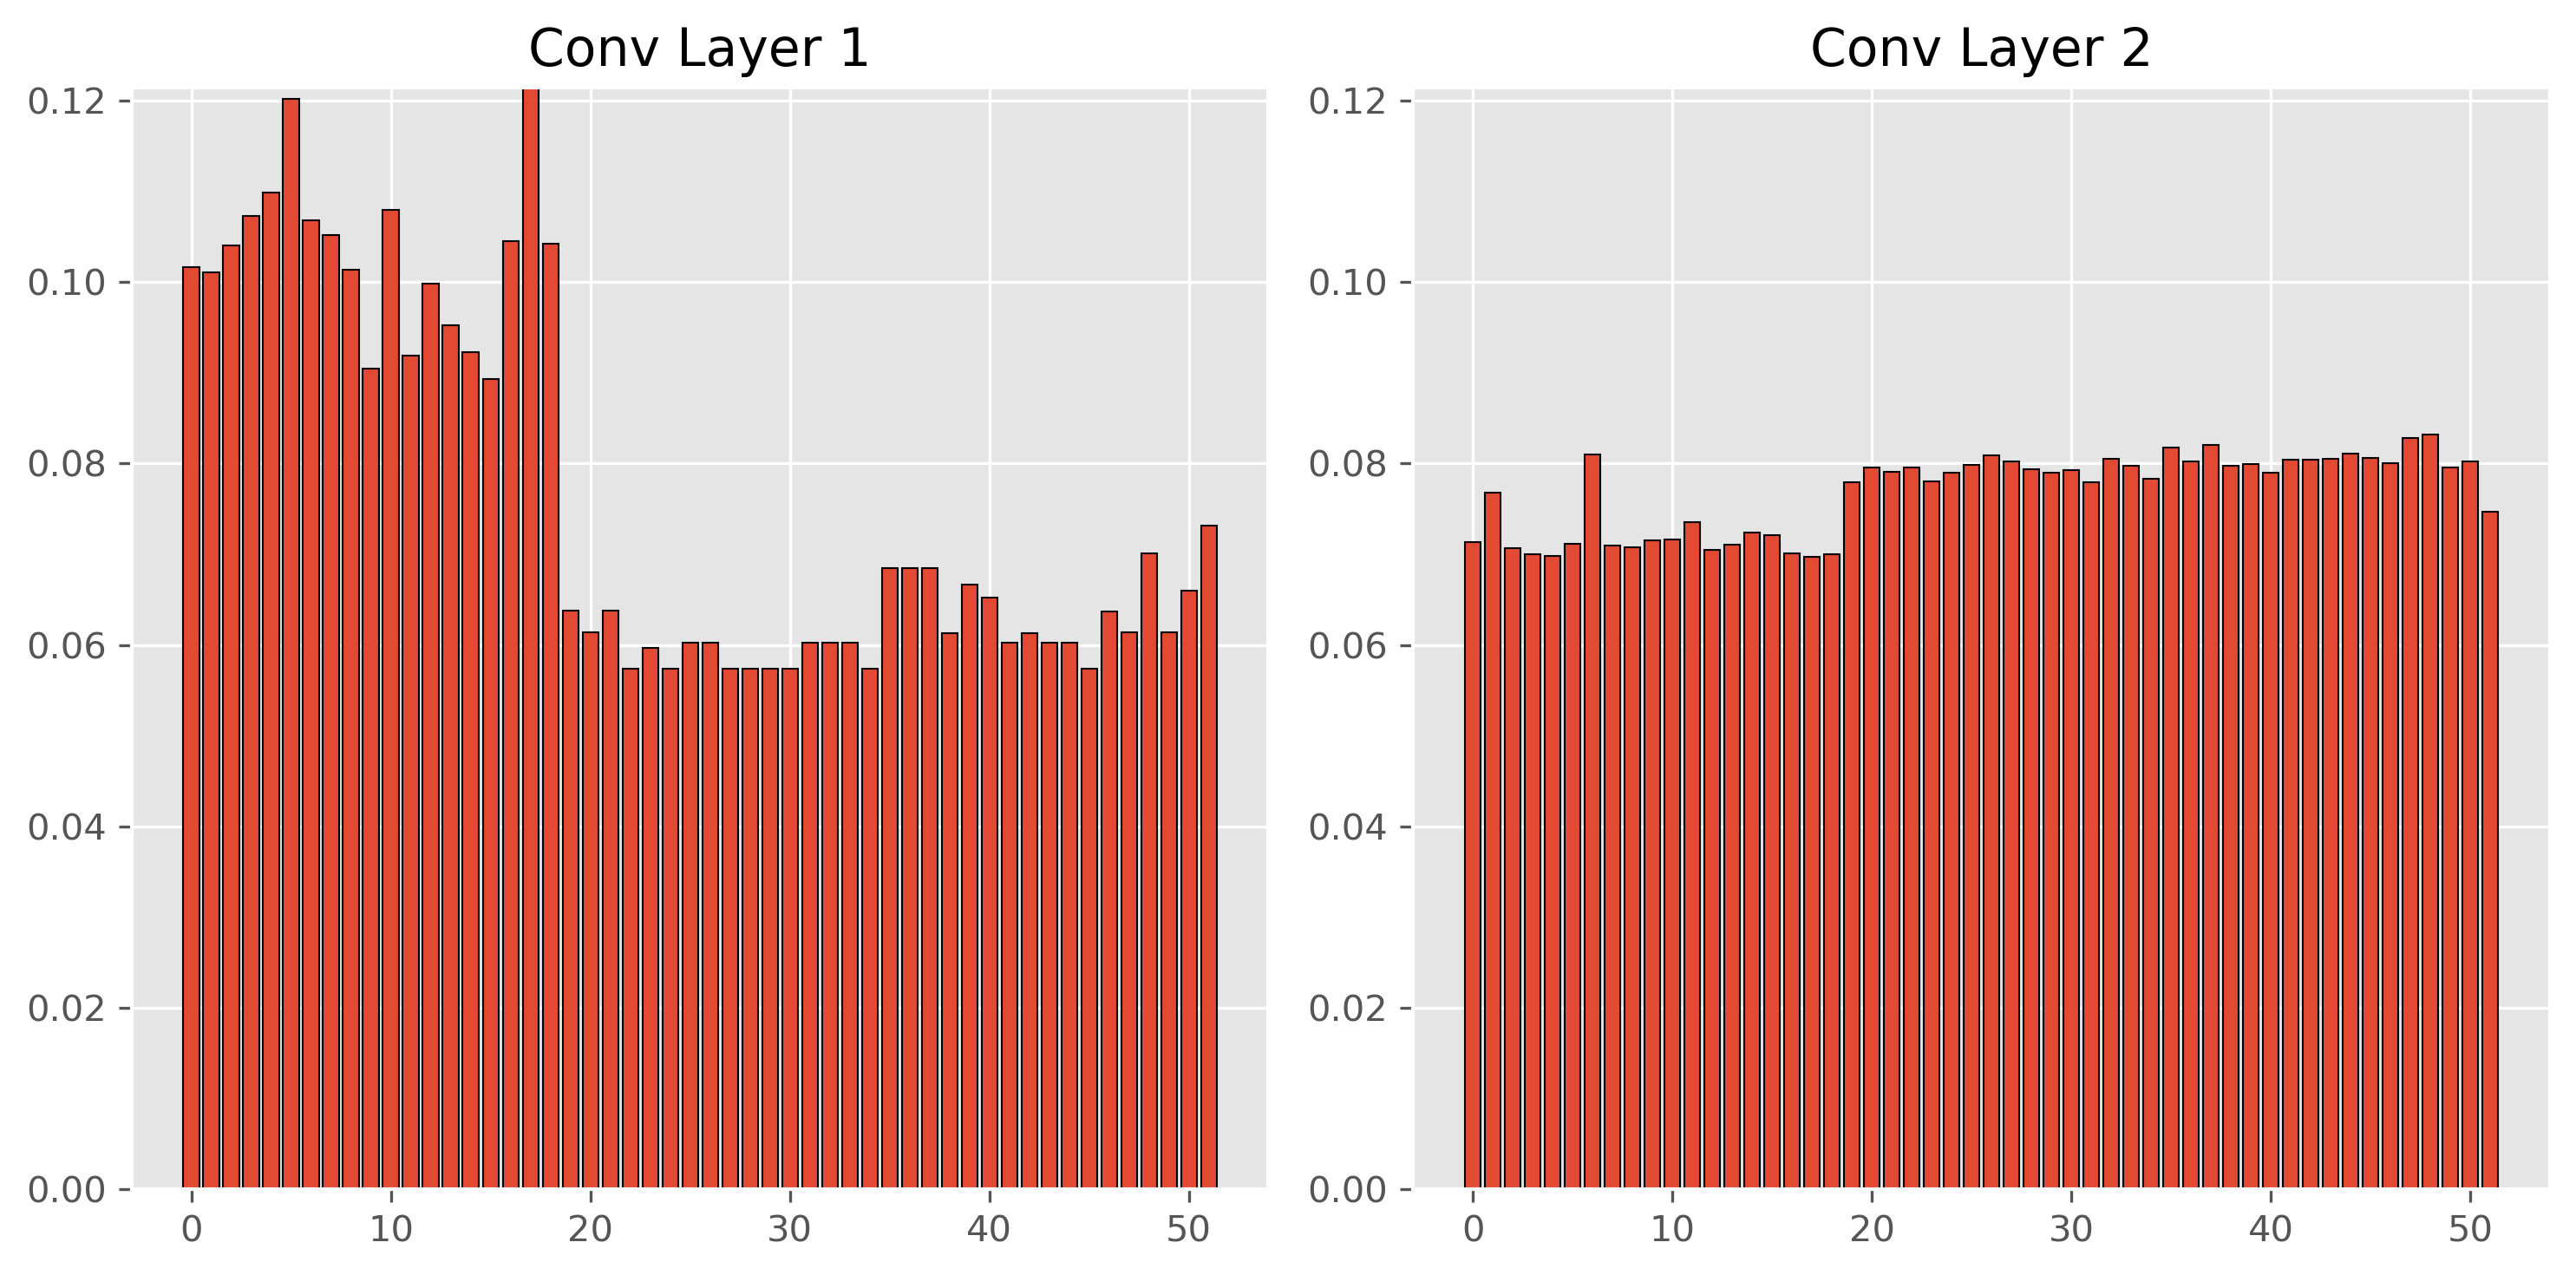

In [31]:
import torch
import matplotlib.pyplot as plt

# Calculate the maximum value across all columns for consistent y-axis range
layer1 = torch.sum(mn_w_conv[:, :4], axis=1)
layer2 = torch.sum(mn_w_conv[:, 4:], axis=1)
max_value = max(layer1.tolist() + layer2.tolist())

# Create a figure with 2x4 subplots
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# Iterate over each subplot and plot histogram for each column
axs[0].bar(range(mn_w_conv.shape[0]), layer1, edgecolor='black')
axs[0].set_title(f'Conv Layer 1')
axs[0].set_ylim(0, max_value)  # Set the same y-axis range for all plots

axs[1].bar(range(mn_w_conv.shape[0]), layer2, edgecolor='black')
axs[1].set_title(f'Conv Layer 2')
axs[1].set_ylim(0, max_value)  # Set the same y-axis range for all plots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

In [32]:
input_nodes

tensor([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 51])

In [33]:
for col in range(8):
    print(torch.std(mn_w_conv[:,col]))

tensor(0.0078, dtype=torch.float64)
tensor(0.0046, dtype=torch.float64)
tensor(0.0054, dtype=torch.float64)
tensor(0.0048, dtype=torch.float64)
tensor(0.0008, dtype=torch.float64)
tensor(0.0017, dtype=torch.float64)
tensor(0.0014, dtype=torch.float64)
tensor(0.0008, dtype=torch.float64)


In [34]:
ah = torch.sum(mn_w_conv[:,:], axis=1)
ah.shape

torch.Size([52])

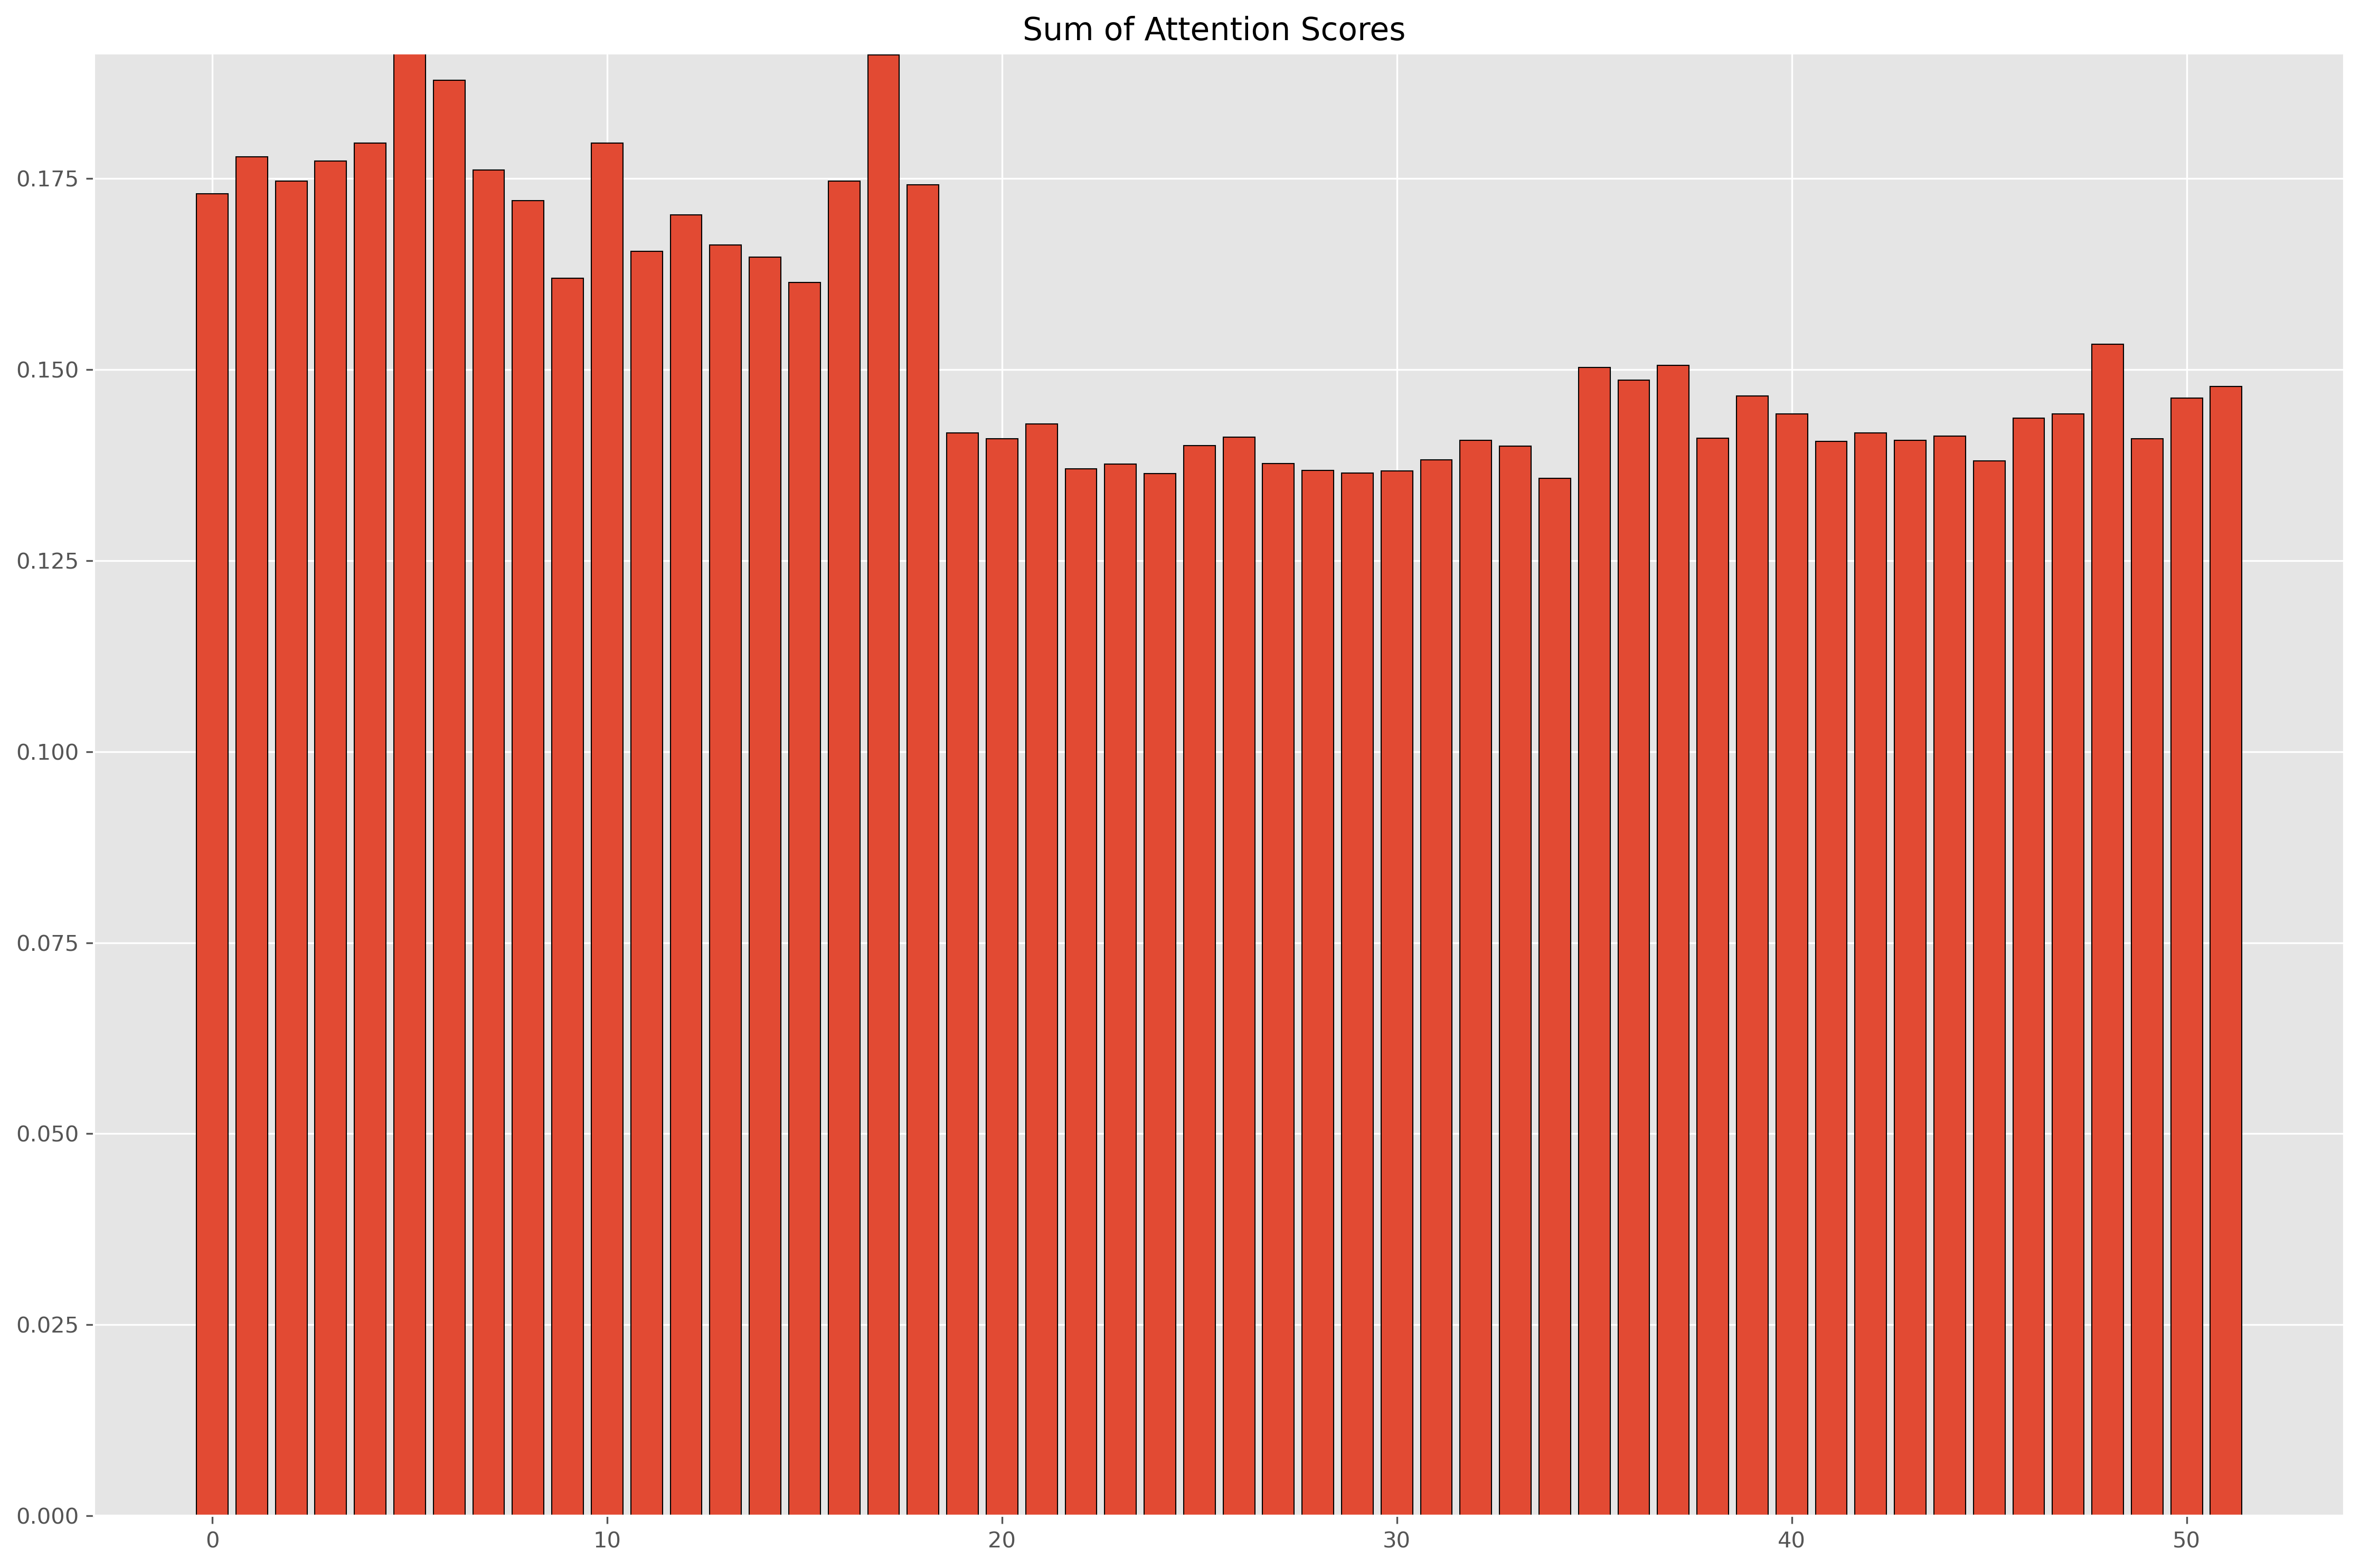

In [35]:
# Calculate the maximum value across all columns for consistent y-axis range
max_value = ah.max().item()

# # Create a figure with 2x4 subplots
fig, axs = plt.subplots(1, 1, figsize=(15, 10))

# # Iterate over each subplot and plot histogram for each column
# for i in range(2):
#     for j in range(4):

axs.bar(range(ah.shape[0]), ah, edgecolor='black')
axs.set_title(f'Sum of Attention Scores ')
axs.set_ylim(0, max_value)  # Set the same y-axis range for all plots

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

In [36]:
torch.std(ah)

tensor(0.0172, dtype=torch.float64)

In [37]:
nodes = []
scores = []

for node, score in sorted(zip(input_nodes.tolist(), ah.tolist())):
    nodes.append(node)
    scores.append(score)

nodes = torch.tensor(nodes)
scores = torch.tensor(scores)

In [38]:
nodes

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [39]:
scores

tensor([0.1417, 0.1410, 0.1429, 0.1370, 0.1376, 0.1364, 0.1401, 0.1412, 0.1377,
        0.1368, 0.1365, 0.1367, 0.1382, 0.1407, 0.1400, 0.1358, 0.1503, 0.1487,
        0.1505, 0.1410, 0.1466, 0.1442, 0.1406, 0.1417, 0.1407, 0.1413, 0.1381,
        0.1437, 0.1442, 0.1533, 0.1409, 0.1462, 0.1730, 0.1779, 0.1747, 0.1773,
        0.1797, 0.1914, 0.1879, 0.1761, 0.1721, 0.1619, 0.1797, 0.1655, 0.1703,
        0.1663, 0.1647, 0.1614, 0.1747, 0.1912, 0.1742, 0.1478])

### Split the scores into prot and lig and normalize individually

In [40]:
scores_lig = scores[nodes < graph.n_lig_nodes]

lowest = torch.min(scores_lig)
highest = torch.max(scores_lig)
print(lowest, highest)

scores_lig_scaled = (((scores_lig - lowest) / (highest - lowest)) + 1) ** 5 
scores_lig_scaled = scores_lig_scaled + 10
scores_lig_scaled

tensor(0.1358) tensor(0.1779)


tensor([11.9377, 11.7932, 12.1777, 11.1545, 11.2399, 11.0797, 11.6230, 11.8270,
        11.2504, 11.1307, 11.0834, 11.1180, 11.3243, 11.7435, 11.6112, 11.0000,
        14.3841, 13.7997, 14.4968, 11.7953, 13.1316, 12.4877, 11.7276, 11.9329,
        11.7441, 11.8569, 11.3028, 12.3571, 12.4921, 15.7001, 11.7853, 13.0371,
        33.7335, 42.0000, 36.3741, 40.8577])

In [41]:
scores_prot = scores[nodes >= graph.n_lig_nodes]

lowest = torch.min(scores_prot)
highest = torch.max(scores_prot)
print(lowest, highest)

scores_prot_scaled = (((scores_prot - lowest) / (highest - lowest)) + 1) ** 5 
scores_prot_scaled = scores_prot_scaled + 10
scores_prot_scaled

tensor(0.1478) tensor(0.1914)


tensor([25.5220, 42.0000, 36.0625, 22.2041, 19.1525, 14.0718, 25.5210, 15.4960,
        17.9993, 15.8630, 15.1449, 13.8795, 21.0413, 41.6403, 20.6515, 11.0000])

In [42]:
ah_scaled = torch.concat([scores_lig_scaled, scores_prot_scaled], axis = 0)
ah_scaled

tensor([11.9377, 11.7932, 12.1777, 11.1545, 11.2399, 11.0797, 11.6230, 11.8270,
        11.2504, 11.1307, 11.0834, 11.1180, 11.3243, 11.7435, 11.6112, 11.0000,
        14.3841, 13.7997, 14.4968, 11.7953, 13.1316, 12.4877, 11.7276, 11.9329,
        11.7441, 11.8569, 11.3028, 12.3571, 12.4921, 15.7001, 11.7853, 13.0371,
        33.7335, 42.0000, 36.3741, 40.8577, 25.5220, 42.0000, 36.0625, 22.2041,
        19.1525, 14.0718, 25.5210, 15.4960, 17.9993, 15.8630, 15.1449, 13.8795,
        21.0413, 41.6403, 20.6515, 11.0000])

In [43]:
# lowest = torch.min(scores)
# highest = torch.max(scores)
# print(lowest, highest)

# ah_scaled = (((scores - lowest) / (highest - lowest)) + 1) ** 5 
# ah_scaled = ah_scaled + 10
# ah_scaled

In [44]:
graph

Data(x=[59, 360], edge_index=[2, 497], edge_attr=[497, 17], y=0.6278598431600422, pos=[59, 3], n_nodes=59, id='4rfm', n_lig_nodes=36)

In [45]:
# graph.x[:,320:329]

In [46]:
#graph.pos

In [48]:
from f_visualize_AA_IntGraph_DTI4_attention_weights import visualize_graph

visualize_graph(graph, 
                graph.id, 
                markersize=(ah_scaled).tolist(),
                linewidth=3,
                show_edge_attr=False, 
                show_edges=True,
                remove_noncov_edges=True)



[1, 1, 1, 1, 2, 2, 1, 1, 3, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 5, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8]
